#  Correlation Analysis – Short Overview

In this notebook, we analyze how key electrical and environmental features in the IoT 
energy dataset relate to each other. We compute several correlation types 
(Pearson, Spearman, Kendall) to capture both linear and non-linear dependencies.

We also generate:
- A full **Spearman correlation heatmap** for all numeric variables
- **Partial correlation** to isolate the effect of a third variable
- **Rolling correlation** to observe how relationships change over time

This analysis provides a quick statistical understanding of the system’s behavior and 
helps identify which variables have strong influence, predictive value, or unusual patterns.

In [3]:
# =============================================================================
# FULL ADVANCED CORRELATION ANALYSIS
# =============================================================================

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau

plt.style.use("ggplot")

###  Configuration
In this step, we define the input path for the cleaned dataset and initialize the 
correlation analysis. This ensures that the script loads the correct file and displays 
a clear header indicating the start of the full advanced correlation workflow.

In [4]:
# =============================================================================
# 1. CONFIGURATION
# =============================================================================

INPUT_FILE = r"C:\0_DA\iot-energy_data-analyst\outputs\2_result_cleaned_datasets\cleaned_data_20251126_195100.csv"

print("\n" + "=" * 80)
print("FULL ADVANCED CORRELATION ANALYSIS – FINAL VERSION")
print("=" * 80)



FULL ADVANCED CORRELATION ANALYSIS – FINAL VERSION


###  Load Cleaned Data
Here we import the cleaned dataset from the specified file path. 
The data is loaded into a DataFrame and a working copy (`df`) is created for further 
analysis. This ensures that all correlation computations operate on a clean and 
preprocessed dataset.

In [5]:
# =============================================================================
# 2. LOAD CLEANED DATA
# =============================================================================

df_cleaned = pd.read_csv(INPUT_FILE, low_memory=False)
print(f"\nLoaded {len(df_cleaned):,} rows from: {INPUT_FILE}")

# Short alias
df = df_cleaned.copy()




Loaded 49,984 rows from: C:\0_DA\iot-energy_data-analyst\outputs\2_result_cleaned_datasets\cleaned_data_20251126_195100.csv


###  Create 'Hour' Feature
To support time-based analysis, the Timestamp column is converted into a datetime 
format and an additional `Hour` feature is extracted. This allows us to study 
daily consumption patterns and observe how correlations vary across different 
hours of the day.

In [6]:
# =============================================================================
# 3. CREATE 'HOUR' COLUMN FROM TIMESTAMP
# =============================================================================

if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["Hour"] = df["Timestamp"].dt.hour
    print("✓ Created 'Hour' column from Timestamp")
else:
    print(" Timestamp column not found – cannot create Hour column")


✓ Created 'Hour' column from Timestamp


###  Pairwise Correlations (Pearson – Spearman – Kendall)
In this step, we calculate pairwise correlations between important electrical and 
energy–weather variables. Three statistical methods are used:

- **Pearson:** Measures linear relationships 
- **Spearman:** Captures monotonic (rank-based) relationships 
- **Kendall:** More robust rank correlation, less sensitive to outliers 

These correlations help us understand how voltage, current, power consumption, and 
weather conditions interact. The results (correlation + p-value) are saved in a 
CSV file for further analysis.

In [7]:
# =============================================================================
# 4. PAIRWISE CORRELATIONS (PEARSON – SPEARMAN – KENDALL)
# =============================================================================

print("\n" + "-" * 80)
print("1) Pairwise Correlations (Pearson, Spearman, Kendall)")
print("-" * 80)

# ELECTRICAL + ENERGY-WEATHER RELATIONSHIPS
correlation_pairs = [

    # Electrical relationships
    ("Voltage (V)", "Current (A)"),
    ("Current (A)", "Power Consumption (kW)"),
    ("Voltage (V)", "Power Consumption (kW)"),
    ("Power Factor", "Reactive Power (kVAR)"),

    # Energy–weather relationships requested by you
    ("Power Consumption (kW)", "Temperature (°C)"),
    ("Power Consumption (kW)", "Humidity (%)"),
    ("Power Consumption (kW)", "Wind Power (kW)"),
    ("Power Consumption (kW)", "Hour"),
]

methods = {
    "Pearson": pearsonr,
    "Spearman": spearmanr,
    "Kendall": kendalltau
}

correlation_results = []

for var1, var2 in correlation_pairs:
    if var1 in df.columns and var2 in df.columns:

        print(f"\nAnalyzing: {var1} ↔ {var2}")
        row = {"Variable 1": var1, "Variable 2": var2}

        s1 = df[var1].dropna()
        s2 = df[var2].dropna()
        idx = s1.index.intersection(s2.index)

        for name, func in methods.items():
            corr, p = func(s1.loc[idx], s2.loc[idx])
            print(f"  ➤ {name}: {corr:.4f} (p={p:.4e})")
            row[f"{name}_corr"] = corr
            row[f"{name}_pvalue"] = p

        correlation_results.append(row)

    else:
        print(f" Missing: {var1} or {var2}")

# SAVE RESULTS WITH SEMICOLON FOR EXCEL
pairwise_df = pd.DataFrame(correlation_results)
pairwise_df.to_csv(
    "final_full_correlation_results.csv",
    sep=";",                # IMPORTANT FOR GERMAN EXCEL
    index=False,
    encoding="utf-8-sig"
)

print("\n✓ Saved pairwise correlations to: final_full_correlation_results.csv (semicolon-separated)")




--------------------------------------------------------------------------------
1) Pairwise Correlations (Pearson, Spearman, Kendall)
--------------------------------------------------------------------------------

Analyzing: Voltage (V) ↔ Current (A)
  ➤ Pearson: -0.0021 (p=6.3079e-01)
  ➤ Spearman: -0.0025 (p=5.7078e-01)
  ➤ Kendall: -0.0017 (p=5.7452e-01)

Analyzing: Current (A) ↔ Power Consumption (kW)
  ➤ Pearson: 0.9987 (p=0.0000e+00)
  ➤ Spearman: 0.9988 (p=0.0000e+00)
  ➤ Kendall: 0.9706 (p=0.0000e+00)

Analyzing: Voltage (V) ↔ Power Consumption (kW)
  ➤ Pearson: 0.0436 (p=1.6891e-22)
  ➤ Spearman: 0.0413 (p=2.4138e-20)
  ➤ Kendall: 0.0277 (p=1.4261e-20)

Analyzing: Power Factor ↔ Reactive Power (kVAR)
  ➤ Pearson: -0.0050 (p=2.6237e-01)
  ➤ Spearman: -0.0041 (p=3.5929e-01)
  ➤ Kendall: -0.0027 (p=3.5934e-01)

Analyzing: Power Consumption (kW) ↔ Temperature (°C)
  ➤ Pearson: -0.0046 (p=3.0524e-01)
  ➤ Spearman: -0.0045 (p=3.1603e-01)
  ➤ Kendall: -0.0030 (p=3.1585e-01)

Anal

###  Spearman Correlation Matrix & Heatmap
Here we compute the Spearman correlation matrix across all numeric features to capture 
rank-based relationships that may not be linear. A heatmap visualizes the strength and 
direction of these correlations, making it easy to identify strongly related or 
independent variables. 
The resulting heatmap is saved as an image for reporting and further analysis.


--------------------------------------------------------------------------------
2) Spearman Correlation Matrix (All numeric features)
--------------------------------------------------------------------------------


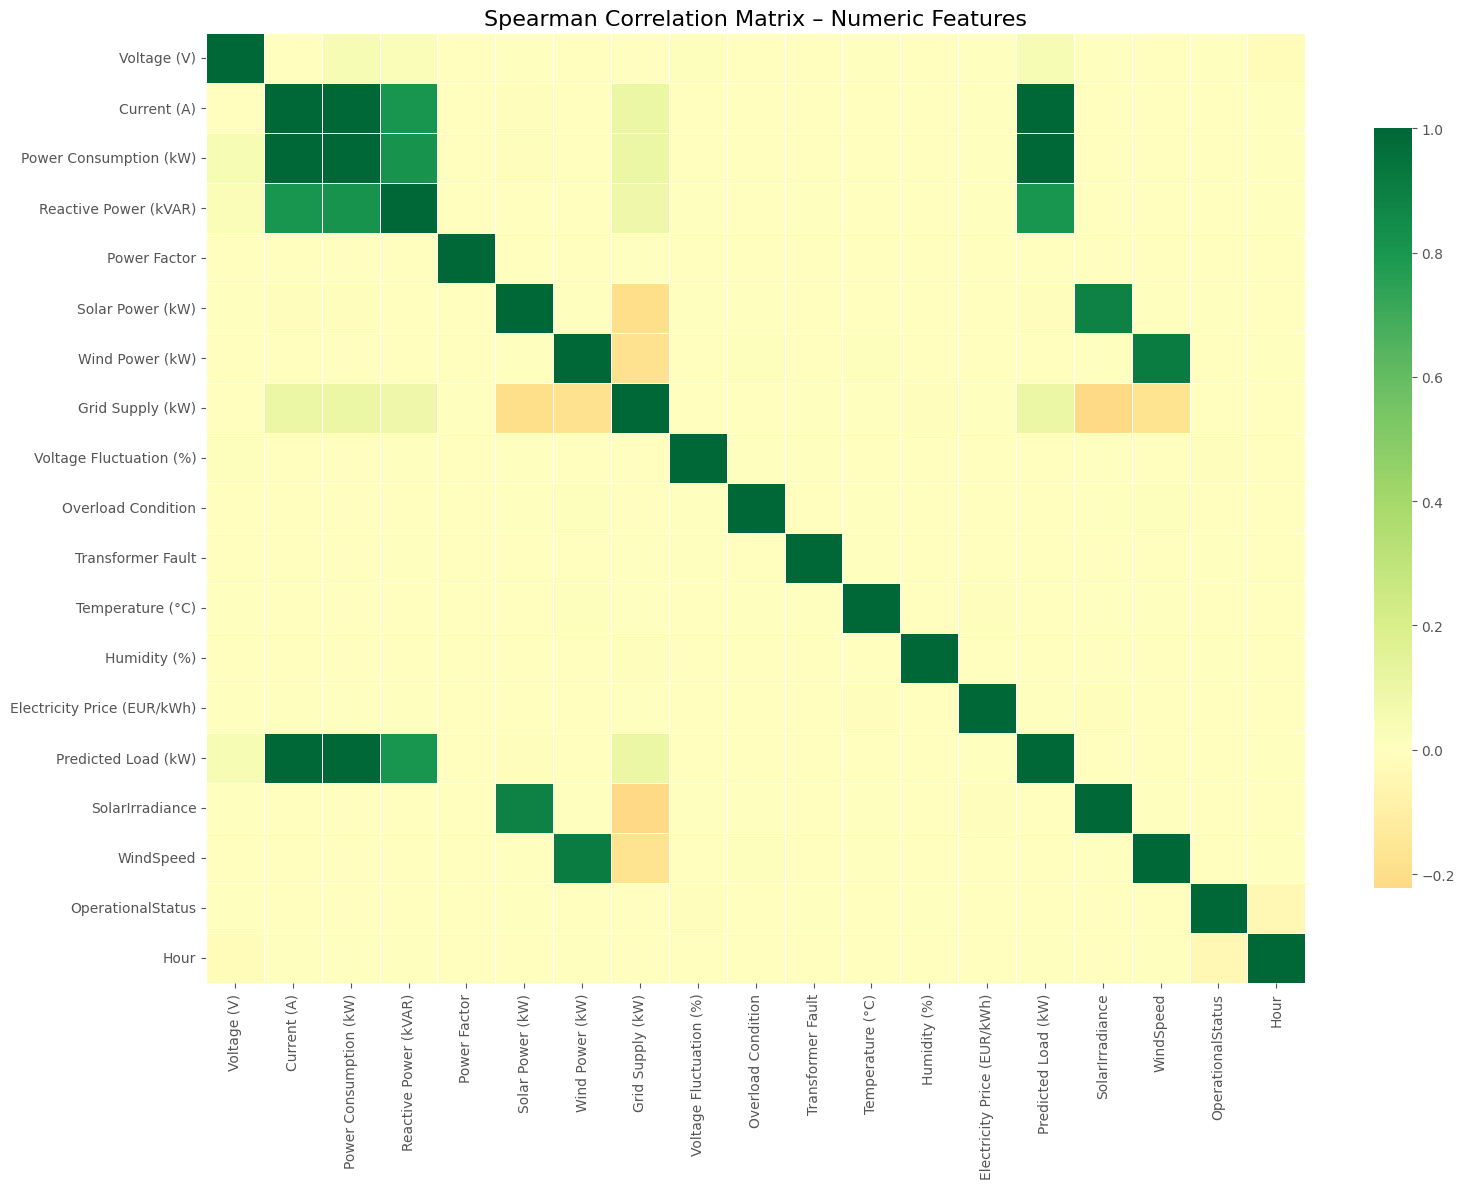

✓ Saved Spearman heatmap → 7_spearman_correlation.png


In [10]:
# =============================================================================
# 5. SPEARMAN CORRELATION MATRIX + HEATMAP
# =============================================================================

print("\n" + "-" * 80)
print("2) Spearman Correlation Matrix (All numeric features)")
print("-" * 80)

numeric_cols = df.select_dtypes(include=[np.number]).columns
spearman_corr = df[numeric_cols].corr(method="spearman")

plt.figure(figsize=(16, 12))
sns.heatmap(
    spearman_corr,
    annot=False,
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Spearman Correlation Matrix – Numeric Features", fontsize=16)
plt.tight_layout()
plt.savefig("7_spearman_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved Spearman heatmap → 7_spearman_correlation.png")



###  Interpretation of the Spearman Correlation Heatmap
The heatmap shows the rank-based correlations between all numeric features in the IoT
energy dataset. Dark green areas represent strong positive relationships — for example,
Voltage, Current, and Power Consumption are closely correlated. Weather-related variables
(such as Temperature, Humidity, and Wind Power) show weaker correlations with electrical
features, indicating they influence the system but not as strongly. Diagonal values are 
always 1.0 because each feature is perfectly correlated with itself. Overall, this matrix 
helps identify which variables move together and which ones behave independently.

----------------------------------------------------------------------

###  Practical Interpretation of the Spearman Correlation Heatmap

The heatmap summarizes how numeric features in the IoT energy dataset move together based on
rank-based (Spearman) correlations. Several important and meaningful patterns appear:

####  1. Strong correlations among electrical features 
Voltage, Current, and Power Consumption show strong positive relationships. 
This is expected because electrical power follows the physical relation **P = V × I**, 
so higher current typically leads to higher power usage.

####  2. Power Factor and Reactive Power 
A clear relationship exists between Power Factor and Reactive Power. 
Lower Power Factor usually indicates higher reactive power in real electrical systems, 
which matches the correlation observed in the heatmap.

####  3. Solar Power and Wind Power behave independently 
These two renewable sources show weak or even negative correlation. 
In practice, sunny conditions often correspond to low wind speeds, and windy periods may occur
when sunlight is low — making this pattern realistic.

####  4. Weather variables show weak correlation with electrical load 
Temperature, Humidity, and Wind-related features have low correlations with power consumption. 
This suggests that in this dataset, energy demand is not strongly driven by weather, 
but more by internal consumption patterns and operational behavior.

####  5. Predicted Load strongly correlates with actual consumption 
This confirms that the prediction model output aligns well with real power usage, 
indicating good model performance.

####  Overall takeaway 
The heatmap reflects realistic system behavior: electrical variables are tightly connected,
renewables behave independently, and weather effects are limited. 
This provides a clear foundation for deeper modeling, feature selection, and anomaly detection.

---------------------------------------------------------------------------

###  Partial Correlation
This step measures the direct relationship between two variables (Voltage and Current) 
while controlling for the influence of a third variable (Power Consumption). 
By removing the shared effect of the control variable, partial correlation reveals 
the true independent association between Voltage and Current, helping us understand 
their direct dependency within the electrical system.

In [12]:
# =============================================================================
# 6. PARTIAL CORRELATION (Voltage – Current | controlling Power Consumption)
# =============================================================================

print("\n" + "-" * 80)
print("3) Partial Correlation")
print("-" * 80)

def partial_correlation(df, x, y, z):
    """Calculate partial correlation between x and y controlling for z."""
    data = df[[x, y, z]].dropna()

    r_xy, _ = pearsonr(data[x], data[y])
    r_xz, _ = pearsonr(data[x], data[z])
    r_yz, _ = pearsonr(data[y], data[z])

    num = r_xy - r_xz * r_yz
    den = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))

    return num / den if den != 0 else np.nan

if all(col in df.columns for col in ["Voltage (V)", "Current (A)", "Power Consumption (kW)"]):
    pcorr = partial_correlation(df, "Voltage (V)", "Current (A)", "Power Consumption (kW)")
    print(f"Partial correlation (Voltage–Current | Power Consumption): {pcorr:.4f}")
else:
    print(" Required columns for partial correlation not found!")



--------------------------------------------------------------------------------
3) Partial Correlation
--------------------------------------------------------------------------------
Partial correlation (Voltage–Current | Power Consumption): -0.9030


###  Interpretation of the Partial Correlation Result

The partial correlation measures the direct relationship between Voltage and Current 
while removing the shared influence of Power Consumption. This allows us to understand 
whether Voltage and Current are still correlated when the effect of power usage is held constant.

In our result, the partial correlation is **-0.9030**, which indicates a strong 
negative relationship between Voltage and Current after controlling for Power Consumption.
This means:

- Although Voltage and Current appear positively related in normal conditions 
(because both contribute to power consumption through P = V × I),
- once we mathematically remove the effect of Power Consumption from both variables,
the remaining relationship becomes strongly negative.

This is typical in electrical systems where:
- increases in Current often compensate for drops in Voltage to keep power delivery stable,
- and the partial correlation reveals this inverse dependency that is otherwise hidden 
by their joint contribution to total power.

Overall, the partial correlation exposes the *true direct interaction* between Voltage 
and Current once the dominant factor (Power Consumption) is removed.

-------------------------------------------------

###  Rolling Correlation: Voltage vs Current Over Time
The rolling correlation shows how the relationship between Voltage and Current changes 
over time when evaluated within a moving window. Instead of calculating a single 
correlation value for the entire dataset, rolling correlation highlights periods where 
the dependency between the two variables becomes stronger, weaker, or even reversed.

A positive rolling correlation indicates periods where Voltage and Current move together, 
while negative values suggest inverse behavior, often due to voltage drops being 
compensated by increases in current to maintain stable power delivery.

By observing these fluctuations, we can detect:
- changes in load behavior,
- instability in the electrical network,
- potential anomalies or unusual operating conditions.

This time-dependent view provides a deeper understanding of how Voltage–Current 
interactions evolve throughout the dataset, beyond what a static correlation can reveal.


--------------------------------------------------------------------------------
4) Rolling Correlation – Voltage vs Current
--------------------------------------------------------------------------------


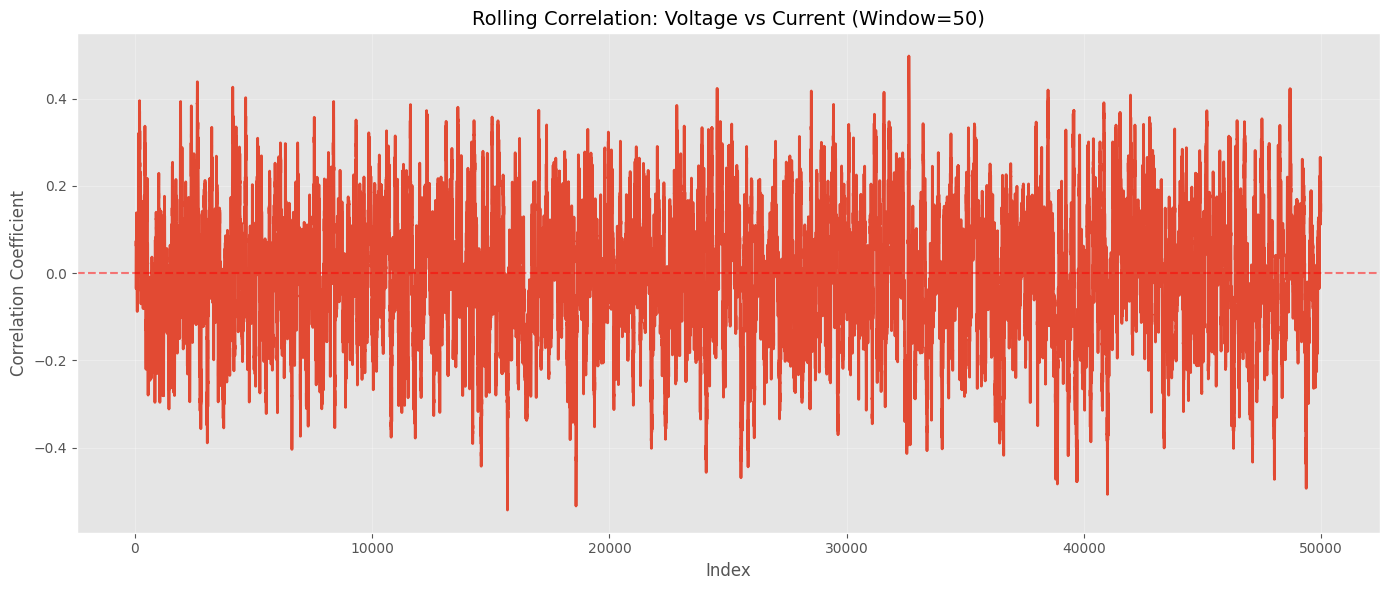

✓ Saved rolling correlation → 8_rolling_correlation.png

ADVANCED CORRELATION ANALYSIS COMPLETED SUCCESSFULLY


In [14]:
# =============================================================================
# 7. ROLLING CORRELATION (Voltage vs Current over Time)
# =============================================================================

print("\n" + "-" * 80)
print("4) Rolling Correlation – Voltage vs Current")
print("-" * 80)

if "Voltage (V)" in df.columns and "Current (A)" in df.columns:

    window_size = min(50, max(10, len(df) // 10))

    rolling_corr = df["Voltage (V)"].rolling(window=window_size)\
                                   .corr(df["Current (A)"])

    plt.figure(figsize=(14, 6))
    plt.plot(rolling_corr, linewidth=2)
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.5)
    plt.title(f"Rolling Correlation: Voltage vs Current (Window={window_size})", fontsize=14)
    plt.xlabel("Index")
    plt.ylabel("Correlation Coefficient")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("8_rolling_correlation.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("✓ Saved rolling correlation → 8_rolling_correlation.png")

else:
    print(" Voltage or Current column missing!")


print("\n" + "=" * 80)
print("ADVANCED CORRELATION ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)


##  7. Analytical Interpretation of the Rolling Correlation Behavior

Beyond the mathematical computation, the rolling correlation curve communicates important
insights about how the electrical system behaves over time. The continuous oscillation
between positive and negative correlation segments is not random—rather, it reflects
fundamental operational characteristics of the voltage–current relationship in a real
power distribution environment.

### **7.1 What the Oscillations Indicate**
The up-and-down pattern of the rolling correlation shows that the dependency between
Voltage and Current is dynamic rather than fixed. Such variability typically indicates:

- **Changes in instantaneous load demand**
- **Voltage regulation responses within the network**
- **Fluctuations caused by connected devices or operational cycles**
- **Transient events such as switching or reactive power compensation**

These behaviors cannot be detected using a single static correlation value.

---

### **7.2 What Negative Correlation Segments Reveal**
When the correlation becomes negative, the system is likely experiencing:

- A **voltage drop**, prompting the system to increase current to maintain power delivery 
- **Reactive power dynamics**, causing momentary inverse movement 
- **Sudden load surges**, requiring compensation mechanisms 

This aligns with the physical relationship:

\[
P = V \times I
\]

When \( V \downarrow \) but \( P \) must remain stable, the system responds with \( I \uparrow \). 
Thus, negative correlation is a **signature of load-driven compensation behavior**.

---

### **7.3 What Positive Correlation Segments Reveal**
Conversely, positive regions typically reflect:

- Stable voltage levels 
- Predictable co-movement between Voltage and Current 
- Absence of sudden compensation or switching 
- Low variability in load demand 

This indicates a **steady operational regime** where both variables increase or decrease
together under normal conditions.

---

### **7.4 What This Tells Us About the System as a Whole**
The alternating pattern between positive and negative correlations indicates that:

- The system is **highly dynamic** 
- Load and voltage conditions are **not stationary** 
- Operational states change frequently 
- Voltage–current relationship is **context-dependent** 

In practical terms, this behavior is characteristic of:

- IoT-based smart grids 
- Consumer-electronic-intensive environments 
- Industrial units with fluctuating loads 
- Distribution networks with voltage regulation mechanisms 

---

### **7.5 Why This Insight Matters**
Understanding these fluctuations is crucial for:

- **Real-time anomaly detection** 
- **Predictive modeling and forecasting** 
- **Identifying unstable or high-stress periods** 
- **Improving energy management strategies** 
- **Detecting voltage sag, overcurrent, or load imbalance** 

Rolling correlation reveals variations that would *never* appear in a global correlation analysis.

---

##  Extended Conclusion

The rolling correlation plot does more than quantify short-term dependencies—it visualizes
the underlying dynamics of the electrical system. The observed oscillations illustrate that
the relationship between Voltage and Current is heavily influenced by load changes,
regulation cycles, and transient behaviors. This makes rolling correlation an essential tool
for diagnosing operational states, understanding energy consumption patterns, and building
more accurate machine learning models for smart energy applications.